In [1]:
import numpy as np
import pickle
import tensorflow as tf

In [2]:
class PMF(tf.keras.Model):
    def __init__(self, n_users, n_items, n_dim):
        super(PMF, self).__init__()
        ## initializing attributes from parameters        
        self.w_u_i_init = tf.keras.initializers.RandomUniform(minval=-1., maxval=1., seed=1)
        
        ## initializing user embedding layer
        ## the output shape should be n_users * n_dim
        self.user_embedding = tf.keras.layers.Embedding(n_users,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        ## initializing user embedding layer
        ## the output shape should be n_items * n_dim
        self.item_embedding = tf.keras.layers.Embedding(n_items,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
        ## users embedding
        self.ub = tf.keras.layers.Embedding(n_users, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
        ## items embedding
        self.ib = tf.keras.layers.Embedding(n_items, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
    def call(self, user_index, item_index):
        ## get the user and item embedding value
        user_h1 = self.user_embedding(user_index)
        item_h1 = self.item_embedding(item_index)
        ## should be checked again
        r_h = tf.math.reduce_sum(user_h1 * item_h1) + tf.squeeze(self.ub(user_index)) + tf.squeeze(self.ib(item_index))
        return r_h

In [13]:
print('===== TRAINING PMF =====')
## initializing hyperparameters
batch_size = 64
epoches = 150
seed = 1
weight_decay = 0.1
emb_dim = 100
ratio = 0.8
lr = 1e-3
momentum = 0.9

## loading dataset
users = pickle.load(open('dataset/user_id_to_num_mov.pkl', 'rb'))
items = pickle.load(open('dataset/movie_id_to_num_mov.pkl', 'rb'))
data = np.load('dataset/data.npy')

print("===== Dataset has been loaded =====")

## As the paper implemented, normalizing the rating
## that will act as reward
data[:, 2] = 0.5 * (data[:, 2] - 3)

## Shuffle data
np.random.shuffle(data)
 
## Splitting data data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]):int((ratio + (1 - ratio) / 2) * data.shape[0])]
test_data = data[int((ratio + ( 1 - ratio ) / 2) * data.shape[0]):]
 
## Extract number of users and items
NUM_USERS = len(users)
NUM_ITEMS = len(items)

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
print("===== Preprocess the data has been finished =====")

model = PMF(NUM_USERS, NUM_ITEMS, emb_dim)
model(1, 1)

print("===== Model Instantiated =====")
model.summary()

# Instantiate an optimizer.
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

def train(train_dataset, len_dataset):
    
    epoch_loss = 0.0
    
    for step, elem in enumerate(train_dataset):
        row = elem[:, 0] ## users as a row
        col = elem[:, 1] ## items as a column
        val = elem[:, 2] ## normalized ratings as value
        
        with tf.GradientTape() as tape:
            
            ## Perlu diperiksa kembali
            row = tf.Variable(row, trainable=False)
            col = tf.Variable(col, trainable=False)
            val = tf.Variable(val, trainable=False)
            
            ## run the forward pass
            logits = model(row, col, training=True)
            
            ## compute the loss value
            loss_value = loss_fn(val, logits)
            
        ## using gradien tape to automatically retrieves
        ## the gradients of the trainable variables with respect to loss
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        ## run one step of gradient descent by updating
        ## the value of variable loss
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss_value
        
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
    
    return float(loss_value)
    
print("===== Training Model =====")
## this list is used for visualization
train_loss_list = []
train_rmse_list = []
vali_rmse_list = []
len_train_data = len(train_data)

last_vali_rmse = None

for epoch in range(epoches):
    ## train epoch losses
    print("\nStart of epoch %d" % (epoch,))
    
    train_epoch_loss = train(train_dataset, len_train_data)
    
    ## test 
    train_loss_list.append(train_epoch_loss)
    
    ## creating index for predicting
    vali_row = tf.Variable(tf.convert_to_tensor(vali_data[:, 0]), trainable=False)
    vali_col = tf.Variable(tf.convert_to_tensor(vali_data[:, 1]), trainable=False)
    
    ## predicting the value
    vali_preds = model(vali_row, vali_col, training=False)
    
    ## calculating rmse
    train_rmse = np.sqrt(train_epoch_loss)
    vali_rmse = np.sqrt(np.square(np.subtract(vali_data[:, 2], vali_preds)).mean())
    
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
    
    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'.format(epoch+1, train_rmse, vali_rmse))
    
    if last_vali_rmse and last_vali_rmse < 0.5:
        break
    else:
        last_vali_rmse = vali_rmse

print("===== Testing Model =====")
test_row = tf.Variable(tf.convert_to_tensor(test_data[:, 0]), trainable=False)
test_col = tf.Variable(tf.convert_to_tensor(test_data[:, 1]), trainable=False)

preds = model(test_row, test_col, training=False)

test_rmse = np.sqrt(np.square(np.subtract(test_data[:, 2], vali_preds)).mean())
print('Test rmse: {:f}'.format(test_rmse))

===== TRAINING PMF =====
===== Dataset has been loaded =====
===== Preprocess the data has been finished =====
===== Model Instantiated =====
Model: "pmf_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    multiple                  94300     
                                                                 
 embedding_21 (Embedding)    multiple                  168200    
                                                                 
 embedding_22 (Embedding)    multiple                  943       
                                                                 
 embedding_23 (Embedding)    multiple                  1682      
                                                                 
Total params: 265,125
Trainable params: 265,125
Non-trainable params: 0
_________________________________________________________________
===== Training Model =====

Start of epoch 0


In [14]:
model.save_weights('trained/adam/pmf_150_adam')

In [38]:
train_data[1]

array([324., 113.,   1.])

In [21]:
x1 = train_data[0, 0]
x2 = train_data[0, 1]

In [39]:
model(324., 113., training=False).numpy()

0.51334107

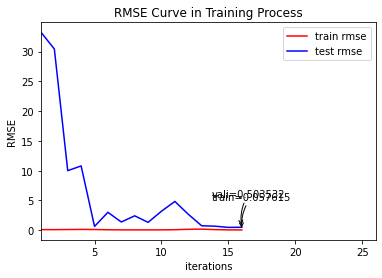

In [33]:
import matplotlib.pyplot as plt

# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='test rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()